<a href="https://colab.research.google.com/github/ttezy/Time-Sequence-Analysis/blob/main/LSTM_Multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Load data**
## **You may need to upload pollution.csv to /content/pollution.csv**

## **Import libs**

In [30]:
from matplotlib import pyplot as plt
import numpy as np

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from numpy import concatenate
from math import sqrt

## **Load dataset**

In [31]:
df=pd.read_csv('pollution.csv',header=0, index_col=0)
df

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


## **Visualize data**

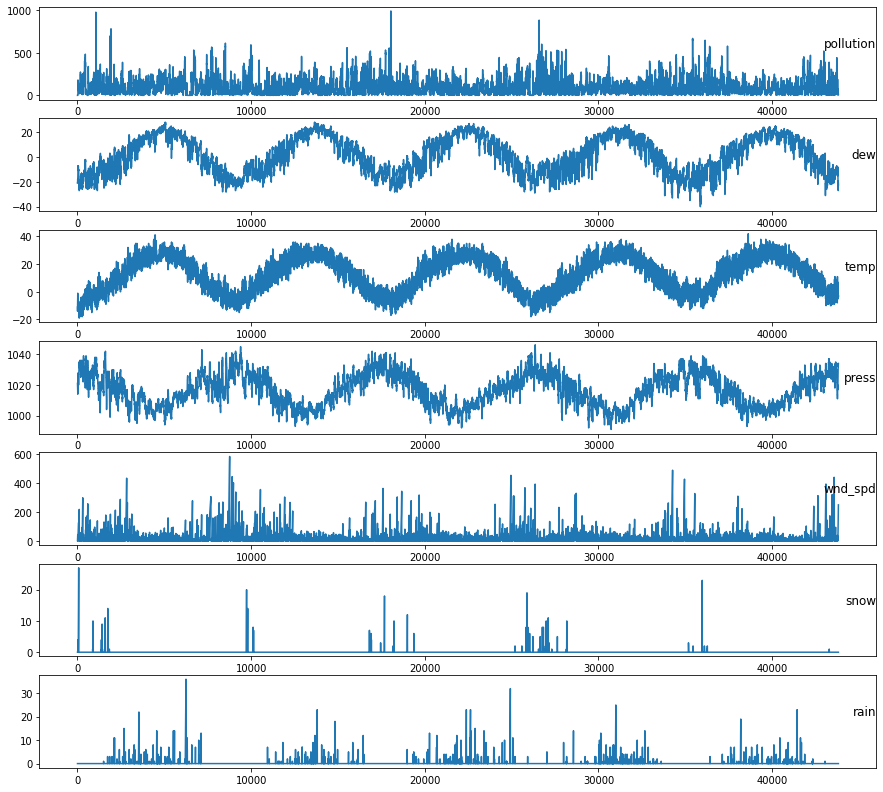

In [32]:
values = df.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize = (15, 14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

# **Step 2: Prepare for model**

## **1 past step to predict 1 future step**





## **Encode wind direction**

In [33]:
# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
# ensure all data is float
values = values.astype('float32')

df['wnd_dir'] = values[:, 4]

df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,1.0,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,1.0,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,1.0,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,1.0,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,1.0,12.97,0,0


## **Normalize data values between 0 and 1**

In [34]:
values = df.values
y_true = values[int(len(values) * 0.9):, 0] # store y_true before the data is scaled

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

## **Reframe dataset for supervised learning**

In [35]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i)[0])
        if i == 0:
            names += ['var1(t)' ]
        else:
            names += [('var1(t+%d)' % (i))]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [36]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)  var1(t)
1        0.0   0.279412   0.131148  ...        0.0        0.0      0.0
2        0.0   0.279412   0.114754  ...        0.0        0.0      0.0
3        0.0   0.279412   0.131148  ...        0.0        0.0      0.0
4        0.0   0.279412   0.081967  ...        0.0        0.0      0.0
5        0.0   0.294118   0.114754  ...        0.0        0.0      0.0

[5 rows x 9 columns]


## **Split training and testing data**

In [37]:
# split into train and test sets
values = reframed.values

# use first 90% data to train
n_train_hours = int(len(values) * 0.9)
train = values[:n_train_hours]
test = values[n_train_hours:]

# split into input and output (var(t-1), var1(t))
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print("train_X shape: ", train_X.shape, " train_y shape: ", train_y.shape,
      "\ntest_X shape: ", test_X.shape, " test_y shape: ", test_y.shape)

train_X shape:  (39440, 1, 8)  train_y shape:  (39440,) 
test_X shape:  (4383, 1, 8)  test_y shape:  (4383,)


# **Step 3: Train LSTM(Long Short-term Memory) model**

## **Design network**

In [38]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

## **Fit model**

In [39]:
epochs = 2 # modify here to choose training epoches
history = model.fit(train_X, train_y, epochs=epochs, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/2
548/548 - 3s - loss: 0.0337 - val_loss: 0.0211
Epoch 2/2
548/548 - 1s - loss: 0.0145 - val_loss: 0.0124


## **Show the training loss and test loss**

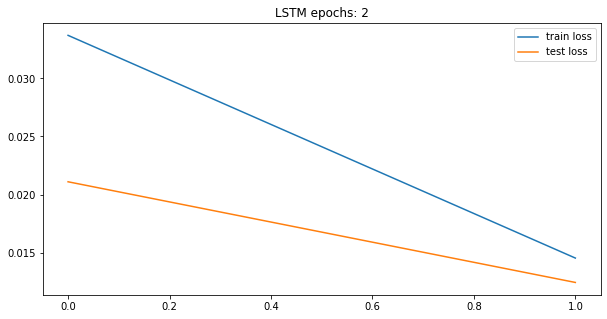

In [40]:
# plot history
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()

# **Step 4: Implement Data Forecasting**

## **Predict future 1-step data based on past 1-step data**

In [41]:
yhat = model.predict(test_X)

## **inverse transform the prediction and the test_y**

In [42]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

## **Calculate RMSE**

In [43]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 22.358


## **Show first 200 predictions**

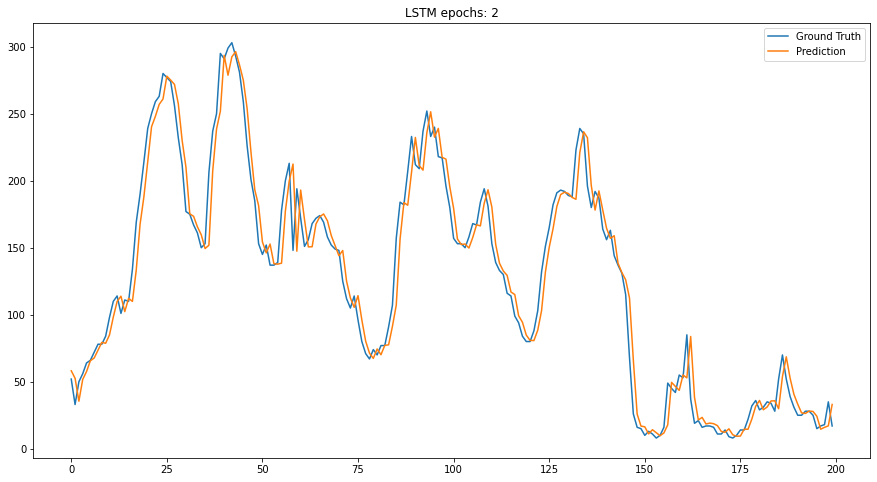

In [44]:
plt.figure(figsize=(15, 8))
plt.plot(inv_y[:200], label='Ground Truth')
plt.plot(inv_yhat[:200], label='Prediction')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()

## **Show first 2000 predictions**

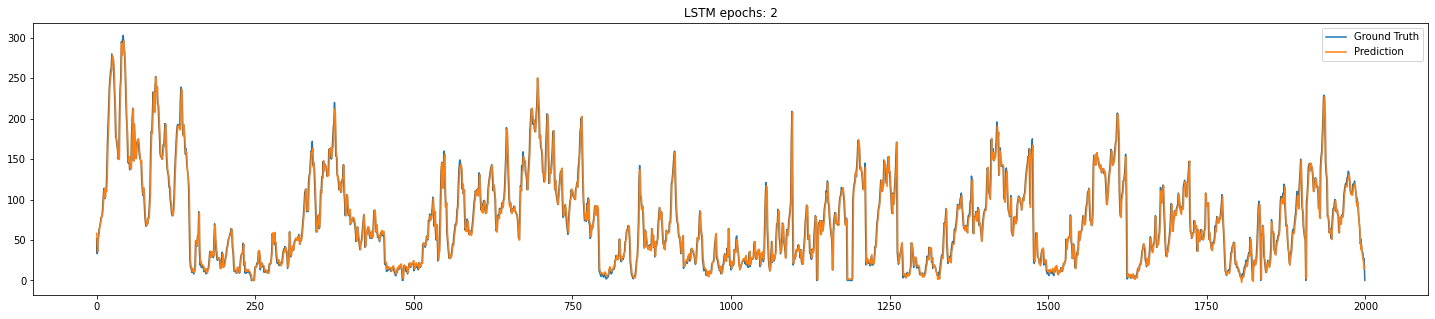

In [45]:
plt.figure(figsize=(25, 5))
plt.plot(inv_y[:2000], label='Ground Truth')
plt.plot(inv_yhat[:2000], label='Prediction')
plt.title("LSTM epochs: " + str(epochs))
plt.legend()
plt.show()

# **Step 5: Test forecasting ability for more future time**

In [52]:
pastStep = 24 # modify here to choose past steps
maxFutureStep = 24  # modify here to choose future steps
epochs = 50 # modify here to choose training epoches

RMSE = np.array([])
prediction = np.array([])
for futureStep in range(1, maxFutureStep+1):  # from 1 to 24
  # frame as supervised learning
  reframed = series_to_supervised(scaled, pastStep, futureStep)

  # split into train and test sets
  values = reframed.values

  # use first 90% data to train
  n_train_hours = int(len(values) * 0.9)
  train = values[:n_train_hours]
  test = values[n_train_hours:]

  # split into input and output
  train_X, train_y = train[:, :-futureStep], train[:, -futureStep:]
  test_X, test_y = test[:, :-futureStep:], test[:, -futureStep:]

  # reshape input to be 3D [samples, timesteps, features]
  train_X_reshape = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  test_X_reshape = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  print("pastStep:", str(pastStep), " futureStep:%2d"%futureStep, 
        "  train X:", train_X_reshape.shape, "  train y:%12s"%str(train_y.shape), 
        "  test X:", test_X_reshape.shape, "  test y:%10s"%str(test_y.shape))
  
  # design network
  model = Sequential()
  model.add(LSTM(50, input_shape=(train_X_reshape.shape[1], train_X_reshape.shape[2])))
  model.add(Dense(futureStep))
  model.compile(loss='mae', optimizer='adam')

  model.fit(train_X_reshape, train_y, epochs=epochs, batch_size=72, validation_data=(test_X_reshape, test_y), verbose=0, shuffle=False, )

  # prediction
  result = model.predict(test_X_reshape)

  # combine prediction results
  pred = np.array([])
  for i in range(0, len(test_X), futureStep):
    pred = np.append(pred, result[i])

  pred = pred[:len(test_X)]
  y_true = y_true[:len(test_X)]

  # inverse transform prediction
  pred = pred.reshape((len(pred), 1))
  inv_pred = concatenate((pred, test_X[:, 1:8]), axis=1)
  inv_pred = scaler.inverse_transform(inv_pred)[:, 0]

  # calculate RMSE
  rmse = sqrt(mean_squared_error(y_true, inv_pred))

  RMSE = np.append(RMSE, rmse)

  if futureStep == 1:
    prediction = np.array([inv_pred])
  else:
    prediction = np.append(prediction, np.array([inv_pred]),axis = 0)

  print("prediction shape:", prediction.shape)

pastStep: 24  futureStep: 1   train X: (39420, 1, 192)   train y:  (39420, 1)   test X: (4380, 1, 192)   test y: (4380, 1)
prediction shape: (1, 4380)
pastStep: 24  futureStep: 2   train X: (39419, 1, 192)   train y:  (39419, 2)   test X: (4380, 1, 192)   test y: (4380, 2)
prediction shape: (2, 4380)
pastStep: 24  futureStep: 3   train X: (39418, 1, 192)   train y:  (39418, 3)   test X: (4380, 1, 192)   test y: (4380, 3)
prediction shape: (3, 4380)
pastStep: 24  futureStep: 4   train X: (39417, 1, 192)   train y:  (39417, 4)   test X: (4380, 1, 192)   test y: (4380, 4)
prediction shape: (4, 4380)
pastStep: 24  futureStep: 5   train X: (39416, 1, 192)   train y:  (39416, 5)   test X: (4380, 1, 192)   test y: (4380, 5)
prediction shape: (5, 4380)


pastStep:  24  futureStep:   1  RMSE: 28.038
pastStep:  24  futureStep:   2  RMSE: 20.166
pastStep:  24  futureStep:   3  RMSE: 33.611
pastStep:  24  futureStep:   4  RMSE: 43.249
pastStep:  24  futureStep:   5  RMSE: 51.336


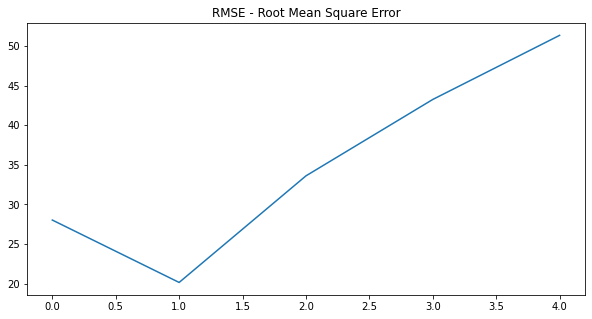

In [54]:
for i in range(len(RMSE)):  
  print("pastStep: %3d" % pastStep, " futureStep: %3d" % (i+1), " RMSE: %.3f" % RMSE[i])

plt.figure(figsize=(10,5))
plt.plot(RMSE)
plt.title("RMSE - Root Mean Square Error")
plt.show()

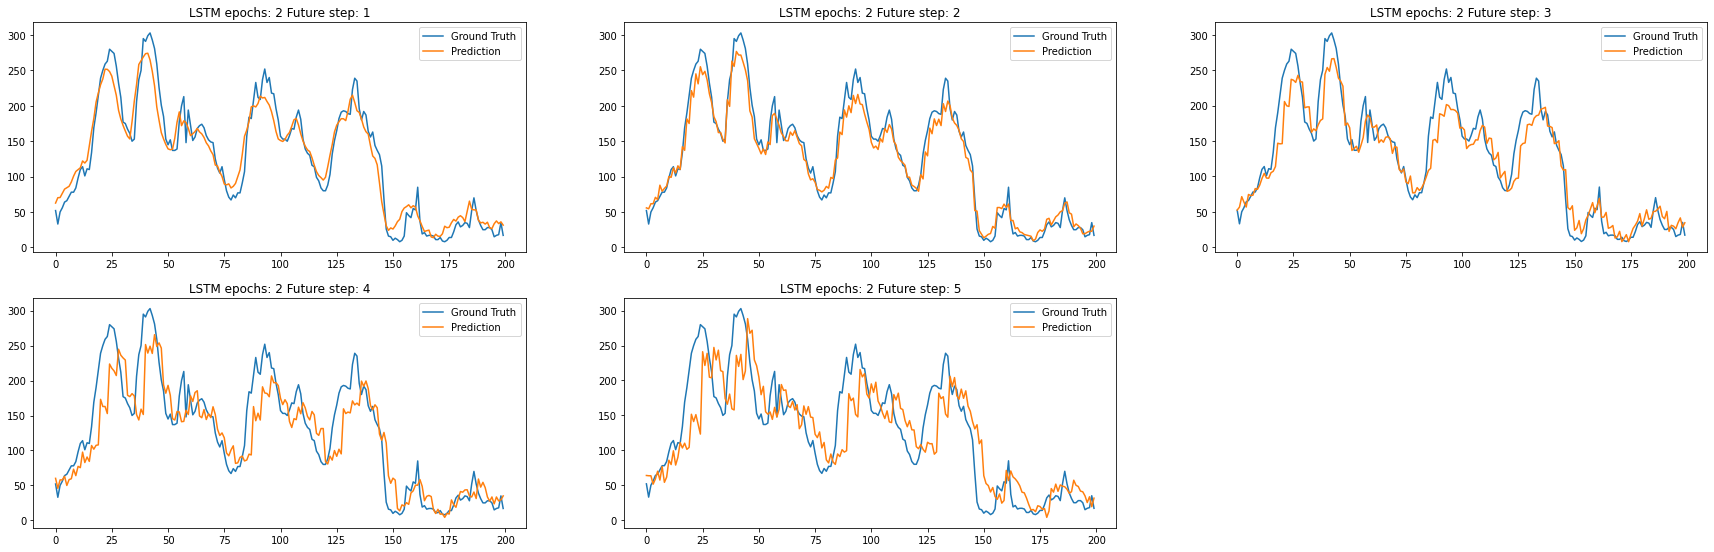

In [56]:
plt.figure(figsize=(30,60))
for i in range(maxFutureStep):
  plt.subplot(12, 3, i+1)
  plt.plot(y_true[:200], label='Ground Truth')
  plt.plot(prediction[i][:200], label='Prediction')
  plt.title("LSTM epochs: " + str(epochs) + " Future step: " + str(i+1))
  plt.legend()
plt.show()

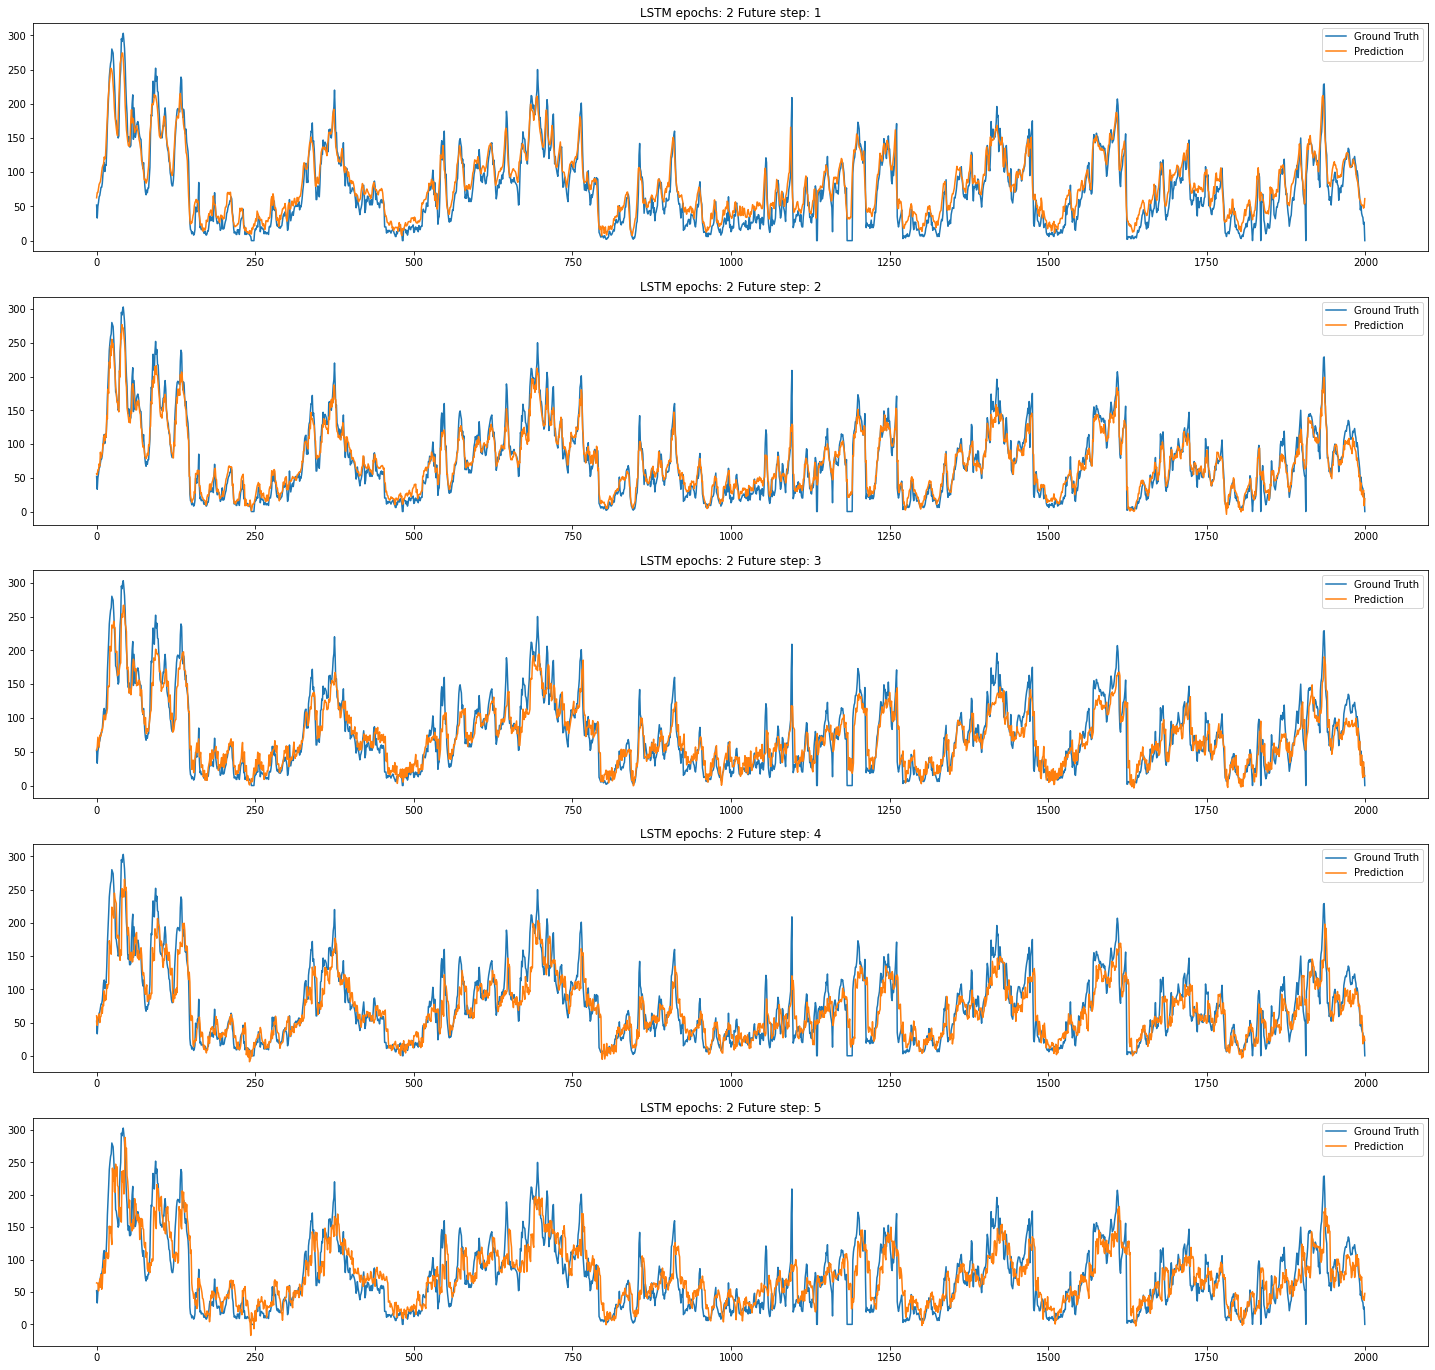

In [58]:
plt.figure(figsize=(25, 24*5))
for i in range(maxFutureStep):
  plt.subplot(24, 1, i+1)
  plt.plot(y_true[:2000], label='Ground Truth')
  plt.plot(prediction[i][:2000], label='Prediction')
  plt.title("LSTM epochs: " + str(epochs) + " Future step: " + str(i+1))
  plt.legend()
plt.show()